In [1]:
# Import Data Preprocessing and Wrangling libraries
import re
import requests
from tqdm.notebook import tqdm
import pandas as pd 
import numpy as np
from datetime import datetime

# Import NLP Libraries
import nltk
import sklearn
import tensorflow
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

# Import sklearn Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
import graphviz

# Import Visualization Libraries
import matplotlib.pyplot as plt
import random as rd
import seaborn as sns

# wordcloud
from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator

# Downloading periphrals
nltk.download('stopwords')
stop_words = stopwords.words('english')

2022-12-03 05:12:15.701170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xingyuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# define function to clean tweets
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    # lowercase all the letters
    temp = tweet.lower()
    
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    
    # remove hashtages and mentions
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    
    # remove links
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub(r"www.\S+", "", temp)
    
    # remove punctuations
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    
    # flitering non-alphanumeric characters
    temp = re.sub("[^a-z0-9]"," ", temp)
    
    # remove stop word
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    
    # put text into a list 
    temp = " ".join(word for word in temp)
    return temp

In [3]:
# import dataset and check
df = pd.read_csv('data/prochoice_prolife.csv')
df.head()

,Unnamed: 0,author_id,author_name,author_username,created_at,id,public_metrics,text,retweet_count,like_count,target
0,28588,73506221,Oregon Right to Life,OR_RTL,2022-06-23 00:00:06+00:00,1539760170900799490,"{'retweet_count': 5, 'reply_count': 0, 'like_c...",We know that unsupported pregnancies can gener...,5,13,1
1,28587,96631851,αιяgσ*мαтι¢*σρтιχ,sacraficial,2022-06-23 00:01:14+00:00,1539760456977395712,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",If you are murdered by a George W. Bush weapon...,0,0,1
2,28586,3041829701,skb,skb37027,2022-06-23 00:04:30+00:00,1539761277702213633,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",.@MarshaBlackburn so much for #ProLife. https:...,0,0,1
3,28537,177260708,Right To Life League,Right2LifeLg,2022-06-23 00:09:50+00:00,1539762620055552001,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",Follow our instagram for more posts like this!...,6,19,1
4,27450,1523376591052582912,No Forced Birth,NoForcedBirth,2022-06-23 00:09:57+00:00,1539762647922421763,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Another classy tweet from the forced birth cro...,0,1,0


In [4]:
# Select useful columns
df = df[['created_at', 'text', 'retweet_count', 'like_count', 'target']]
df.head()

,created_at,text,retweet_count,like_count,target
0,2022-06-23 00:00:06+00:00,We know that unsupported pregnancies can gener...,5,13,1
1,2022-06-23 00:01:14+00:00,If you are murdered by a George W. Bush weapon...,0,0,1
2,2022-06-23 00:04:30+00:00,.@MarshaBlackburn so much for #ProLife. https:...,0,0,1
3,2022-06-23 00:09:50+00:00,Follow our instagram for more posts like this!...,6,19,1
4,2022-06-23 00:09:57+00:00,Another classy tweet from the forced birth cro...,0,1,0


In [5]:
# Transform 'created_at' column into datetime format
df['original_text'] = df['text']
df['datetime'] = df["created_at"]
df = df.drop('created_at', axis=1)
df['datetime'] = df['datetime'].astype(str).apply(lambda x: x.split('+')[0])
df['datetime'] = df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df.head()

,text,retweet_count,like_count,target,original_text,datetime
0,We know that unsupported pregnancies can gener...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06
1,If you are murdered by a George W. Bush weapon...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14
2,.@MarshaBlackburn so much for #ProLife. https:...,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30
3,Follow our instagram for more posts like this!...,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50
4,Another classy tweet from the forced birth cro...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57


In [6]:
# clean tweets
tweets_text = df['text']
results = [clean_tweet(tw) for tw in tweets_text]
df['text'] = results
df.head()

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_54087/3658592801.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


,text,retweet_count,like_count,target,original_text,datetime
0,know unsupported pregnancies generate lot fear...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06
1,murdered george w bush weapon war died free bo...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14
2,much,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30
3,follow instagram posts like,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50
4,another classy tweet forced birth crowd idea g...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57


In [7]:
# Feature Extraction
import math
df['words'] = df.text.apply(lambda x:re.findall(r'\w+', x ))
df['words_count'] = df.words.apply(len)
df['sentence_length'] = df.text.apply(len)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df['date'] = df.datetime.apply(lambda x: x.date())
df['month'] = df.datetime.apply(lambda x: x.month)
df.head()

,text,retweet_count,like_count,target,original_text,datetime,words,words_count,sentence_length,hour,date,month
0,know unsupported pregnancies generate lot fear...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06,"[know, unsupported, pregnancies, generate, lot...",20,146,0,2022-06-23,6
1,murdered george w bush weapon war died free bo...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14,"[murdered, george, w, bush, weapon, war, died,...",15,85,0,2022-06-23,6
2,much,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30,[much],1,4,0,2022-06-23,6
3,follow instagram posts like,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50,"[follow, instagram, posts, like]",4,27,0,2022-06-23,6
4,another classy tweet forced birth crowd idea g...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57,"[another, classy, tweet, forced, birth, crowd,...",13,75,0,2022-06-23,6


In [8]:
# produces a 60%, 20%, 20% split for training, validation and test sets.
TrainData, ValidData, TestData = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(TrainData.shape, ValidData.shape, TestData.shape)

(33624, 12) (11208, 12) (11208, 12)


In [9]:
ReviewsLIST = []  ## from the text column
LabelLIST = []

for nextreview, nextlabel in zip(TrainData["text"], TrainData["target"]):
    ReviewsLIST.append(nextreview)
    LabelLIST.append(nextlabel)

In [10]:
# stem 
A_STEMMER = PorterStemmer()

def MY_STEMMER(str_input):
    # Only use letters, no punct, no nums, make lowercase...
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [A_STEMMER.stem(word) for word in words]
    return words

# Vectorize and Instantiate your CV
MyCountV = CountVectorizer(
    input="content",
    lowercase=True,
    stop_words="english",  # Remove stopwords
    tokenizer=MY_STEMMER,  # Stemming
    max_features=10000  # This can be updated, keeping the top 10000
)

# Use your CV
MyDTM = MyCountV.fit_transform(ReviewsLIST)  # create a sparse matrix
ColumnNames = MyCountV.get_feature_names()  # This is the vocab

# clean up the columns
MyDTM_DF = pd.DataFrame(MyDTM.toarray(), columns=ColumnNames)
# Convert the labels from list to df
Labels_DF = pd.DataFrame(LabelLIST, columns=['LABEL'])

for nextcol in tqdm(MyDTM_DF.columns):
    # The following will remove all columns that contains numbers
    if str.isdigit(nextcol):
        MyDTM_DF = MyDTM_DF.drop([nextcol], axis=1)

    # The following will remove any column with name of 3 or smaller - like "it" or "of" or "pre".
    elif len(str(nextcol)) < 3:
        MyDTM_DF = MyDTM_DF.drop([nextcol], axis=1)

# Save original DF - without the lables
My_Orig_DF = MyDTM_DF

/Users/xingyuchen/miniconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
# completed dataframe
dfs = [Labels_DF, MyDTM_DF]
Final_DF_Labeled = pd.concat(dfs, axis=1, join='inner')
## DF with labels
print(Final_DF_Labeled.shape)

## Create list of all words
NumCols = Final_DF_Labeled.shape[1]

top_words = list(Final_DF_Labeled.columns[1:NumCols + 1])

(33624, 9698)


In [12]:
## Encoding the data
def Encode(review):
    words = review.split()
    # print(words)
    if len(words) > 500:
        words = words[:500]
        # print(words)
    encoding = []
    for word in words:
        try:
            index = top_words.index(word)
        except:
            index = (NumCols - 1)
        encoding.append(index)
    while len(encoding) < 500:
        encoding.append(NumCols)
    return encoding

In [13]:
# Encode our training and testing dataset with same vocab.
print(TestData.shape)
print(TrainData.shape)

############### Final Training and Testing data and labels-----------------
training_data = np.array([Encode(review) for review in tqdm(TrainData["text"])])
print(training_data.shape)
testing_data = np.array([Encode(review) for review in tqdm(TestData['text'])])
validation_data = np.array([Encode(review) for review in tqdm(ValidData['text'])])

train_labels = np.array([TrainData['target']])
train_labels = train_labels.T
print(train_labels.shape)
test_labels = np.array([TestData['target']])
test_labels = test_labels.T

(11208, 12)
(33624, 12)


  0%|          | 0/33624 [00:00<?, ?it/s]

(33624, 500)


  0%|          | 0/11208 [00:00<?, ?it/s]

  0%|          | 0/11208 [00:00<?, ?it/s]

(33624, 1)


In [14]:
def eval_model(model):
    print("Evaluate model on test data")
    results = model.evaluate(testing_data, test_labels, batch_size=256)
    print("test loss, test acc:", results)

    print("Generate a prediction")
    prediction = model.predict(testing_data)
    prediction[prediction > .5] = 1
    prediction[prediction <= .5] = 0
    print(prediction)
    print(prediction.shape)
    print(confusion_matrix(prediction, test_labels))

In [15]:
# ANN 
input_dim = NumCols + 1 
input_data = tensorflow.keras.layers.Input(shape=(500))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=64, input_length=500)(input_data)
data = tensorflow.keras.layers.Flatten()(data) 
data = tensorflow.keras.layers.Dense(16)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(8)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(4)(data)
data = tensorflow.keras.layers.Activation('sigmoid')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))
eval_model(model)

2022-12-03 05:40:38.706425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 64)           620736    
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 16)                512016    
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136   

In [16]:
# RNN
input_data = tensorflow.keras.layers.Input(shape=(500))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.SimpleRNN(50))(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))
eval_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 32)           310368    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              8300      
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 318,769
Trainable params: 318,769
Non-trainable params: 0
_____________________________________________________

In [17]:
# LSTM
input_data = tensorflow.keras.layers.Input(shape=(500))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(50))(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()
model.fit(training_data, train_labels, epochs=10, batch_size=128, validation_data=(testing_data, test_labels))
eval_model(model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 32)           310368    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              33200     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
 activation_5 (Activation)   (None, 1)                 0         
                                                                 
Total params: 343,669
Trainable params: 343,669
Non-trainable params: 0
_____________________________________________________

In [18]:
# CNN
input_data = tensorflow.keras.layers.Input(shape=(500))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
data = tensorflow.keras.layers.Conv1D(50, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Conv1D(40, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Flatten()(data)
data = tensorflow.keras.layers.Dense(20)(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()
model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))
eval_model(model)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 32)           310368    
                                                                 
 conv1d (Conv1D)             (None, 498, 50)           4850      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 40)           6040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 123, 40)          0         
 1D)                                                       

In [19]:
# word cloud dataset filter 
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]

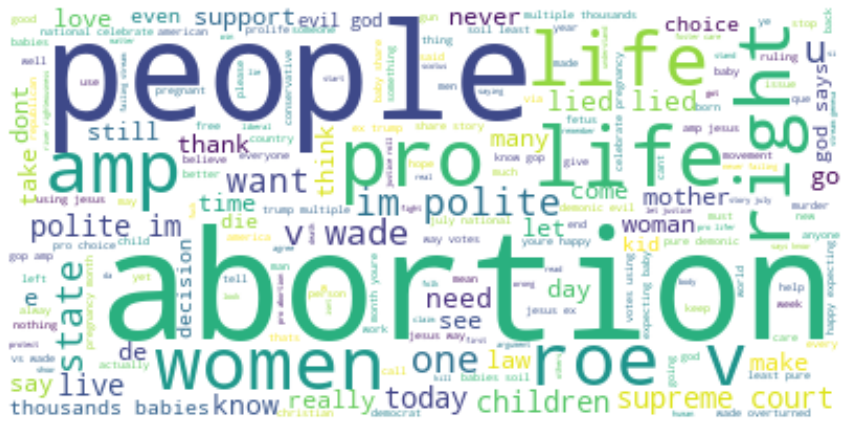

In [20]:
# positive wordcloud
text = " ".join(i for i in data_pos.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

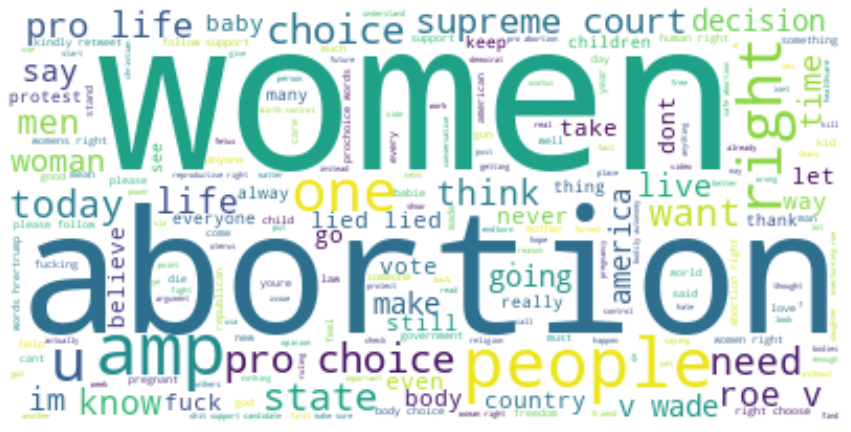

In [21]:
# negative word cloud
text = " ".join(i for i in data_neg.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Data gathering via API - URLs and GET
topics = ["abortion", "antiabortion"]

filename = "NewHeadlines.csv"
MyFILE = open(filename, "w") 
WriteThis = "LABEL,Date,Source,Title,Headline\n"
MyFILE.write(WriteThis)
MyFILE.close()

#### GATHER - CLEAN - CREATE FILE
endpoint = "https://newsapi.org/v2/everything"

for topic in topics:

    ## Dictionary Structure
    URLPost = {'apiKey': '1df08f5f5fd54b8eb321e7d512acd363',
               'q': topic
               }

    response = requests.get(endpoint, URLPost)
    jsontxt = response.json()
    print(jsontxt)
    
    ## Open the file for append
    MyFILE = open(filename, "a")
    LABEL = topic
    for items in jsontxt["articles"]:
        
        Source = items["source"]["name"]
        Date = items["publishedAt"]
        
        ##clean up the date
        NewDate = Date.split("T")
        Date = NewDate[0]

        ## CLEAN the Title, similar to tweets
        Title = items["title"]
        Title = str(Title)
        Title = re.sub(r'[,.;@#?!&$\-\']+', ' ', str(Title), flags=re.IGNORECASE)
        Title = re.sub(' +', ' ', str(Title), flags=re.IGNORECASE)
        Title = re.sub(r'\"', ' ', str(Title), flags=re.IGNORECASE)
        Title = re.sub(r'[^a-zA-Z]', " ", str(Title), flags=re.VERBOSE)
        Title = Title.replace(',', '')
        Title = ' '.join(Title.split())
        Title = re.sub("\n|\r", "", Title)

        Headline = items["description"]
        Headline = str(Headline)
        Headline = re.sub(r'[,.;@#?!&$\-\']+', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(' +', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(r'\"', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(r'[^a-zA-Z]', " ", Headline, flags=re.VERBOSE)
        Headline = Headline.replace(',', '')
        Headline = ' '.join(Headline.split())
        Headline = re.sub("\n|\r", "", Headline)
        Headline = ' '.join([wd for wd in Headline.split() if len(wd) > 3])

        WriteThis = str(LABEL) + "," + str(Date) + "," + str(Source) + "," + str(Title) + "," + str(Headline) + "\n"
        MyFILE.write(WriteThis)

    MyFILE.close()

BBC_DF = pd.read_csv(filename, error_bad_lines=False)
print(BBC_DF.head())
# iterating the columns
for col in BBC_DF.columns:
    print(col)

print(BBC_DF["Headline"])

## REMOVE any rows with NaN in them
BBC_DF = BBC_DF.dropna()

### Tokenize and Vectorize the Headlines
HeadlineLIST = []
LabelLIST = []

for nexthead, nextlabel in zip(BBC_DF["Headline"], BBC_DF["LABEL"]):
    HeadlineLIST.append(nexthead)
    LabelLIST.append(nextlabel)

print("The headline list is:\n")
print(HeadlineLIST)

print("The label list is:\n")
print(LabelLIST)

# remove words in the topic
NewHeadlineLIST = []

for element in HeadlineLIST:
    ## make into list
    AllWords = element.split(" ")

    ## Now remove words that are in your topics
    NewWordsList = []
    for word in AllWords:
        word = word.lower()
        if word in topics:
            
        else:
            NewWordsList.append(word)

    ##turn back to string
    NewWords = " ".join(NewWordsList)
    NewHeadlineLIST.append(NewWords)
    
## Set the HeadlineLIST to the new one
HeadlineLIST = NewHeadlineLIST
print(HeadlineLIST)

### Vectorize and Instantiate your CV
MyCountV = CountVectorizer(
    input="content",
    lowercase=True,
    stop_words="english",
    max_features=50
)

## Use your CV
MyDTM = MyCountV.fit_transform(HeadlineLIST)  # create a sparse matrix
print(type(MyDTM))

ColumnNames = MyCountV.get_feature_names()

## Build the data frame
MyDTM_DF = pd.DataFrame(MyDTM.toarray(), columns=ColumnNames)

## Convert the labels from list to df
Labels_DF = DataFrame(LabelLIST, columns=['LABEL'])

##Save original DF - without the lables
My_Orig_DF = MyDTM_DF

dfs = [Labels_DF, MyDTM_DF]

Final_News_DF_Labeled = pd.concat(dfs, axis=1, join='inner')
## DF with labels
print(Final_News_DF_Labeled)

## Create Training and Testing Data, Then model and test the Decision Tree
List_of_WC = []

for mytopic in topics:
    tempdf = Final_News_DF_Labeled[Final_News_DF_Labeled['LABEL'] == mytopic]

    tempdf = tempdf.sum(axis=0, numeric_only=True)
    # Make var name
    NextVarName = str("wc" + str(mytopic))
    NextVarName = WordCloud(width=1000, height=600, background_color="white",
                            min_word_length=4,  # mask=next_image,
                            max_words=400).generate_from_frequencies(tempdf)

    ## Here, this list holds all three wordclouds I am building
    List_of_WC.append(NextVarName)

print(List_of_WC)
# word cloud
fig = plt.figure(figsize=(25, 25))
NumTopics = len(topics)
for i in range(NumTopics):
    ax = fig.add_subplot(NumTopics, 1, i + 1)
    plt.imshow(List_of_WC[i], interpolation='bilinear')
    plt.axis("off")
    plt.savefig("NewClouds.pdf")

IndentationError: expected an indented block (1021340845.py, line 101)

In [ ]:
training_data = My_Orig_DF
train_labels = pd.factorize(Labels_DF['LABEL'])[0]
train_labels
NumCols = Final_News_DF_Labeled.shape[1]

In [ ]:
# ANN   
input_dim = NumCols + 1 
input_data = tensorflow.keras.layers.Input(shape=(50))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=18, input_length=50)(input_data)
data = tensorflow.keras.layers.Flatten()(data)
data = tensorflow.keras.layers.Dense(16)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(8)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(4)(data)
data = tensorflow.keras.layers.Activation('sigmoid')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(training_data, train_labels, epochs=10)

In [ ]:
# RNN
input_data = tensorflow.keras.layers.Input(shape=(50))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.SimpleRNN(50))(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(training_data, train_labels, epochs=10)

In [ ]:
# LSTM
input_data = tensorflow.keras.layers.Input(shape=(50))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(50))(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(training_data, train_labels, epochs=10)

In [ ]:
# CNN
input_data = tensorflow.keras.layers.Input(shape=(50))
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
data = tensorflow.keras.layers.Conv1D(50, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Conv1D(40, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data) 
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
data = tensorflow.keras.layers.Flatten()(data)
data = tensorflow.keras.layers.Dense(20)(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)

model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(training_data, train_labels, epochs=10)